In [24]:
from pyimzml.ImzMLParser import ImzMLParser

# Load your .imzML file (make sure the .ibd file is in the same directory)
path = "/home/parsa/PycharmProjects/HT-SpaceM/maldi_data/imzML_data/Ifd_8.imzML"  # change to your file name
parser = ImzMLParser(path)

# Basic info
print(f"Total spectra: {len(parser.coordinates)}")
print(f"First coordinate: {parser.coordinates[0]}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/parsa/PycharmProjects/HT-SpaceM/maldi_data/imzML_data/Ifd_8.imzML'

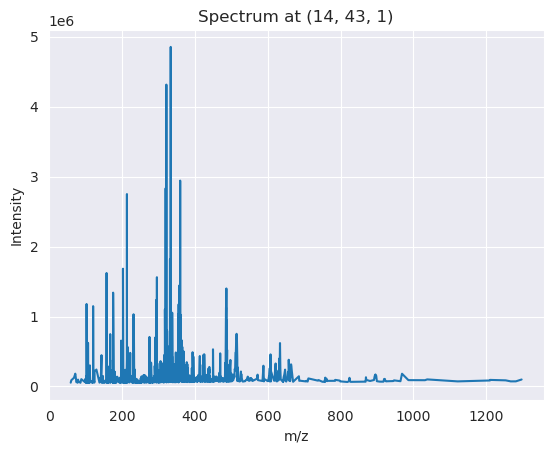

In [25]:
import matplotlib.pyplot as plt

# Choose a random or middle index
index = 4000
coord = parser.coordinates[index]
mzs, intensities = parser.getspectrum(index)

plt.plot(mzs, intensities)
plt.title(f"Spectrum at {coord}")
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.show()


In [26]:
xs = [c[0] for c in parser.coordinates]
ys = [c[1] for c in parser.coordinates]

print(f"x range: {min(xs)} to {max(xs)}")
print(f"y range: {min(ys)} to {max(ys)}")


x range: 1 to 128
y range: 1 to 93


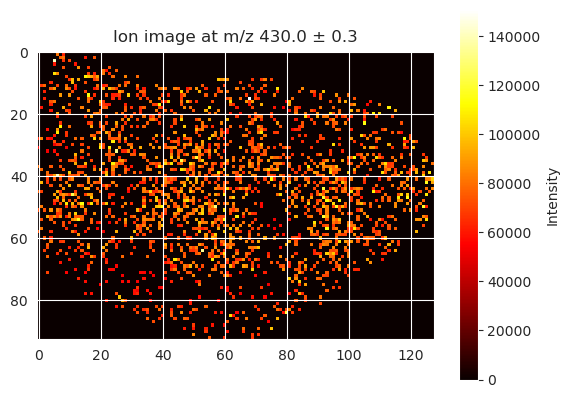

In [27]:
import numpy as np

target_mz = 430.0  # estimate based on the tallest peak (you can adjust ± a few)
tolerance = 0.3    # m/z window around the target


max_x = max(xs)
max_y = max(ys)
ion_image = np.zeros((max_y, max_x))

for i, (x, y, z) in enumerate(parser.coordinates):
    mzs, intensities = parser.getspectrum(i)
    for mz, intensity in zip(mzs, intensities):
        if abs(mz - target_mz) <= tolerance:
            ion_image[y-1, x-1] = intensity
            break

plt.imshow(ion_image, cmap='hot')
plt.title(f"Ion image at m/z {target_mz} ± {tolerance}")
plt.colorbar(label='Intensity')
plt.show()


In [28]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import normalize

# Define m/z binning
min_mz = 100
max_mz = 1000
bin_size = 1.0
bins = np.arange(min_mz, max_mz, bin_size)
num_bins = len(bins)

# Create empty matrix
spectra_matrix = np.zeros((len(parser.coordinates), num_bins))

for i in tqdm(range(len(parser.coordinates))):
    mzs, intensities = parser.getspectrum(i)
    mzs = np.array(mzs)
    intensities = np.array(intensities)

    indices = np.floor((mzs - min_mz) / bin_size).astype(int)
    mask = (indices >= 0) & (indices < num_bins)

    for idx, intensity in zip(indices[mask], intensities[mask]):
        spectra_matrix[i, idx] += intensity

# Normalize each spectrum (TIC or l2)
spectra_matrix = normalize(spectra_matrix, norm='l2')


100%|██████████| 8958/8958 [00:02<00:00, 3005.49it/s]


In [29]:
import umap.umap_ as umap

# Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(spectra_matrix)

# Check shape
print("UMAP shape:", embedding.shape)


/home/parsa/anaconda3/envs/HTSpaceM/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (8958, 2)


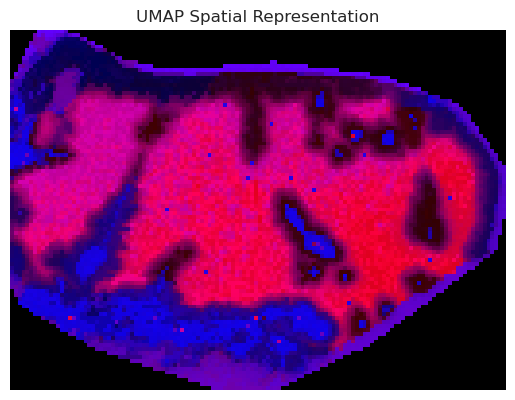

In [30]:
import matplotlib.pyplot as plt

# Get coords
x_coords = [c[0] for c in parser.coordinates]
y_coords = [c[1] for c in parser.coordinates]
max_x = max(x_coords)
max_y = max(y_coords)

# Create RGB UMAP map
umap_image = np.zeros((max_y, max_x, 3))

# Normalize UMAP dimensions to 0–1 for color mapping
umap_min = embedding.min(axis=0)
umap_max = embedding.max(axis=0)
umap_norm = (embedding - umap_min) / (umap_max - umap_min)

# Fill image
for i, (x, y, _) in enumerate(parser.coordinates):
    umap_image[y-1, x-1] = umap_norm[i][:3] if embedding.shape[1] >= 3 else [umap_norm[i][0], 0, umap_norm[i][1]]

plt.imshow(umap_image)
plt.title("UMAP Spatial Representation")
plt.axis("off")
plt.show()
